## Financial analysis: Portfolio management

## Risk analysis

#### Importing necessary libries

In [1]:
import sys
import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import sidetable as stb
import mplfinance as mpf
from scipy.stats import zscore

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import pypfopt
from pypfopt import risk_models, expected_returns, plotting
from pypfopt import objective_functions
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import EfficientCVaR

import quantstats as qs
# sns.set_theme(style='whitegrid')
sns.set_theme('notebook')

In [2]:
sys.path.append(os.path.abspath('../scripts'))
from plotting import Plots
from utils import Utils
from financial_analysis import PortOptimizer

plots = Plots()
portfolio_optimizer = PortOptimizer()

## Portfolio optimization based on historical data

In [3]:
historical_data = yf.download(tickers='TSLA BND SPY', start="2015-01-01", end="2024-10-31")['Close']

[*********************100%***********************]  3 of 3 completed


In [6]:
tsla, bnd, sp500 = Utils.get_price_data()

2024-11-10 01:21 - INFO :: Fetching data took 0.18s


#### Risk model and return model selection

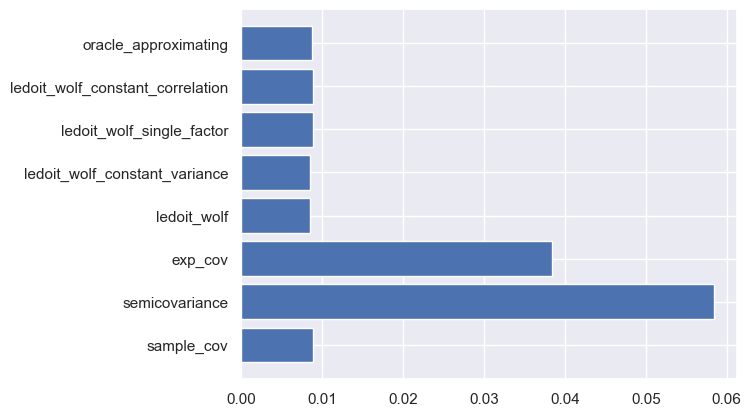

In [4]:
portfolio_optimizer.test_risk_models(historical_data)

**Observation**
- All risk models can be used to calculate the covariance matrix except exp_cov and semicovariance. Since these models have the highest mean absolute errors.

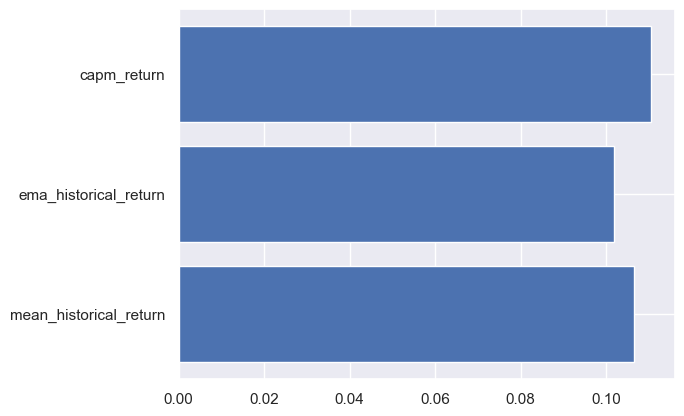

In [5]:
portfolio_optimizer.test_return_models(historical_data)

**Observation**
- To calculate the expected return we can utilize all return calculation models but ema_historical_reutrn seems to have a better MAE score compared to the other models.

**Models used**
- Risk model to calculate covariance matrix: `ledoit_wolf`
- Expected return model: `ema_historical_return`

#### For investors seeking max sharpe ratio

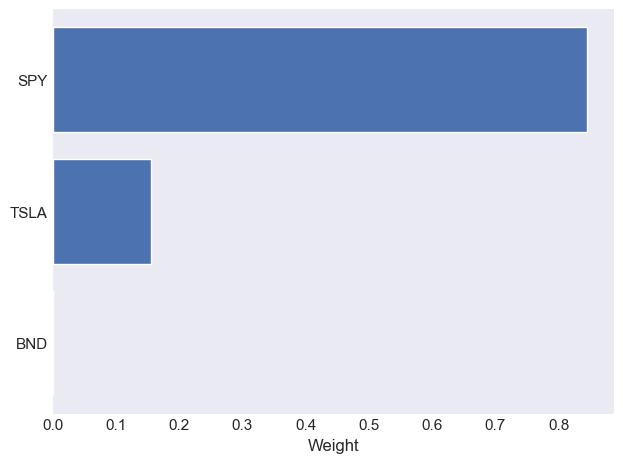

In [4]:
portfolio_optimizer.plot_weights(historical_data, allow_shorts=False, max_return=True)

**Observation**
- For investors seeking maximum sharpe ratio the weights are as follow:
    - More than 80% on S&P500 ETF
    - The rest to Tesla stocks
    - No Vanguard bond

- Below you can see the efficient frontier and how this weights are calulated

Expected annual return: 45.0%
Annual volatility: 20.7%
Sharpe Ratio: 2.08


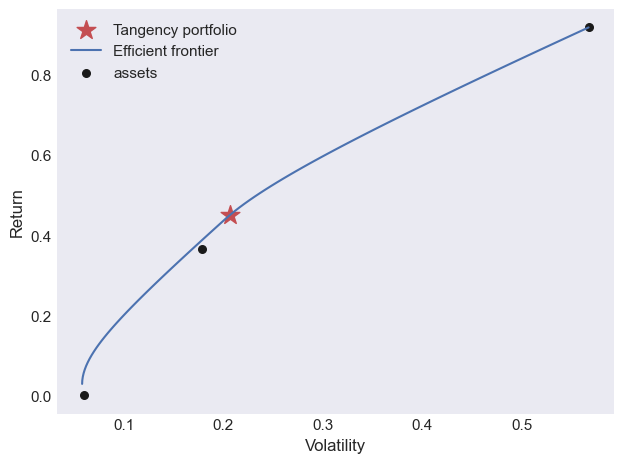

In [7]:
portfolio_optimizer.plot_efficient_frontier(historical_data, allow_shorts=False, max_return=True)

#### For investors seeking minimum volatility

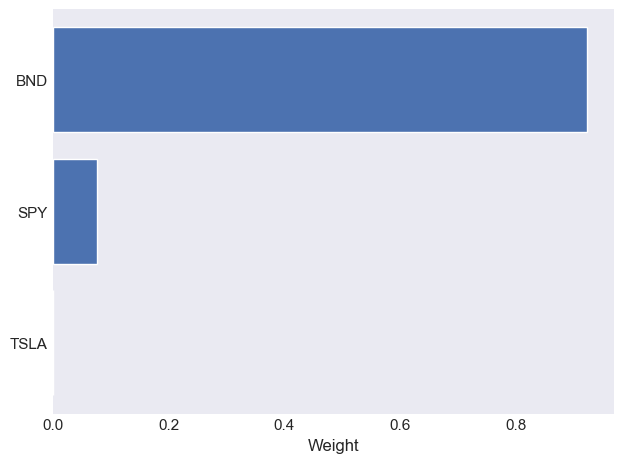

In [5]:
portfolio_optimizer.plot_weights(historical_data, allow_shorts=False, max_return=False)

**Observation**
- For investors seeking minimum risk/volatility the weights are as follow:
    - More than 80% on vanguard Bond ETF
    - The rest to SPY
    - No Tesla stocks

- Below you can see the efficient frontier and how this weights are calulated

Expected annual return: 2.9%
Annual volatility: 5.8%
Sharpe Ratio: 0.16


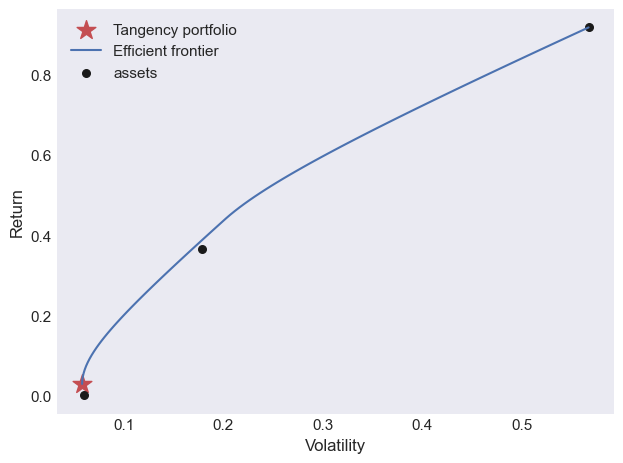

In [6]:
portfolio_optimizer.plot_efficient_frontier(historical_data, allow_shorts=False, max_return=False)

#### Calculating VaR and CVaR

- Value at risk (VaR) is a statistic that quantifies the extent of possible financial losses within a firm, portfolio, or position over a specific time frame. This metric is most commonly used by investment and commercial banks to determine the extent and probabilities of potential losses in their institutional portfolios.

- Conditional Value at Risk (CVaR), also known as the expected shortfall, is a risk assessment measure that quantifies the amount of tail risk an investment portfolio has.


In [19]:
mu = expected_returns.ema_historical_return(historical_data)
S = risk_models.CovarianceShrinkage(historical_data).ledoit_wolf()
returns = expected_returns.returns_from_prices(historical_data).dropna()

ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
# Compute CVaR
portfolio_rets = (returns * weight_arr).sum(axis=1)
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -1.86%
CVaR: -2.97%


**Insights**
- VaR (-1.86%): This value represents the maximum expected loss (in percentage terms) that an investment portfolio could face with a certain probability (e.g., 95% confidence level) over a specified time period. A VaR of -1.86% means that there is a 5% chance that the portfolio could lose at least 1.86% of its value over the defined period.
- CVaR (-2.97%): Conditional Value at Risk, also known as Expected Shortfall, goes beyond VaR by measuring the expected value of the loss given that it exceeds the VaR threshold. In this case, a CVaR of -2.97% implies that if the losses exceed the VaR threshold of -1.86%, the average loss is expected to be 2.97%.

### Efficient CVaR optimization

In [ ]:
# Let's firstly construct the portfolio with the minimum CVaR:
ec = EfficientCVaR(mu, returns)
ec.min_cvar()
ec.portfolio_performance(verbose=True);

Expected annual return: 0.7%
Conditional Value at Risk: 0.78%


**Observation**
- The minimum achievable CVaR value is 0.78% and when this is the case the expected annual return is 0.7%.
- If the accepted CVaR value is 2% we can see how our expected return for our portfolio increases

In [ ]:
ec = EfficientCVaR(mu, returns)
ec.efficient_risk(target_cvar=0.02)
ec.portfolio_performance(verbose=True);

Expected annual return: 16.2%
Conditional Value at Risk: 2.00%


**Observation**
- The CVaR was significantly reduced, albeit with a substantial decrease in returns, when compared to the expected return necessary to achieve the highest Sharpe ratio.
- Optimization for the highest Sharpe ratio yielded the following metrics: 
    - Expected annual return: 45.0%, 
    - Annual volatility: 20.7%, 
    - Sharpe Ratio: 2.08.